In [1]:
import sys
sys.path.append("../../../")
sys.path.append("../../hyperLAI/")
sys.path.append("../../../libraries/")
from utils.model_utils import *
from models.fc_model import fc_model
from features.hyperLAIdataset import HyperLoader
from sklearn.feature_selection import VarianceThreshold
import torch
from torch.utils import data
from features.hyperLAIdataset import HyperLoader
import numpy as np
import json

In [2]:
dataset = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/", chromosome=22)

start reading ...
File read: 317408 SNPs for 3558 individuals
done loading vcf... Shape of vcf file is :  (317408, 3558, 2) Shape of vcf names file is (3558,)
TSV loaded Index(['Sample', 'Population code', 'Population', 'Superpopulation code',
       'Superpopulation', 'Source', 'Latitude', 'Longitude', 'Region',
       'Sample Alias', 'Country', 'Town', 'Single_Ancestry'],
      dtype='object') DF shape is  (3558, 13)
Super population code are ,  ['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS'] 7
Population code are ,  ['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL', 'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH', nan] 27
Population names are ,  ['British', 'Finnish', 'Southern Han Chinese', 'Puerto Rican', 'Dai Chinese', 'Colombian', 'Spanish', 'Peruvian', 'Punjabi', 'Kinh Vietnamese', 'African-Caribbean', 'Gambian Mandinka', 'Esan', 'Bengali', 'Mende', 'Sri Lankan', 'Indian Telugu', 'CEPH', 'Yorub

In [3]:
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), 0.8, 0.1)

In [4]:
variance_filter(dataset, train_indices, 5000)

In [ ]:
snps_train = dataset.snps[train_indices,:]

In [5]:
vt_var = np.var(dataset.snps, axis=0)

In [ ]:
var_sorted = np.argsort(vt_var)[::-1]

In [7]:
dataset.snps.shape

(5930, 5000)

In [ ]:
vt_var[77852]

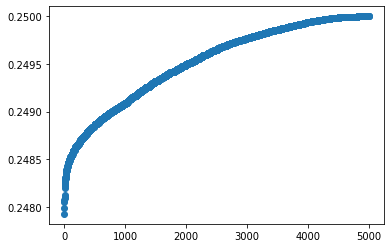

In [6]:
import matplotlib.pyplot as plt
plt.scatter(range(len(vt_var)), sorted(vt_var))
plt.show()

In [ ]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

In [ ]:
np.random.seed(0)
indices = np.array(list(range(len(dataset))))
np.random.shuffle(indices)
train_indices = indices[0 : train_size]
valid_indices = indices[train_size : train_size + valid_size]
test_indices = indices[train_size + valid_size : ]

In [ ]:
# sfunc = lambda x,y: (torch.sum(x == y)).float() / len(x)
sfunc = lambda x,y: torch.true_divide(torch.sum(x==y), len(x))

In [ ]:
snp_data = torch.tensor(np.random.randint(0,2,size=(4,4)))
snp_data

In [ ]:
smat = make_pairwise_similarities(snp_data, sfunc)

In [ ]:
trips, sims = trips_and_sims(snp_data, sfunc)

In [ ]:
trips

In [ ]:
sims

In [ ]:
sims[[2,3],:]

In [ ]:
input_size=20
num_int_layers=1
int_layer_sizes=[5]
embedding_size=2
dropout_vals=[0.8]

In [ ]:
fctest = fc_model(input_size, num_int_layers, int_layer_sizes, embedding_size, dropout_vals)

In [ ]:
list(fctest.parameters())

In [ ]:
def run_epoch(model, dloader, device, sim_func, optimizer=None):
    batch_hyp_losses = []
    for i, (snp_data, suppop_labels, pop_labels) in enumerate(dloader):
        if model.training:
            assert optimizer is not None
            optimizer.zero_grad()
        else:
            assert optimizer is None
        triple_ids, similarities = trips_and_sims(snp_data, sim_func)
        snp_data = snp_data.to(device)
        triple_ids = triple_ids.to(device)
        similarities = similarities.to(device)
        embeddings_pred = model(snp_data)
        hyp_loss = model.loss(embeddings_pred, triple_ids, similarities)
        batch_hyp_losses.append(hyp_loss.item())
        if model.training:
            hyp_loss.backward()
            optimizer.step()
    return batch_hyp_losses
        
        

In [ ]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate, sim_func,
               patience, txt_writer, output_dir, early_stopping, 
                patience, early_stop_min_delta, optimizer=None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if device == torch.device("cuda"):
        print("Training occurring on GPU")
        model = model.to(device)
    if optimizer is None:
        optimizer = RAdam(model.parameters(), lr=learning_rate)
    if early_stopping:
        valid_loss_history = []
    best_valid_epoch_loss, best_model = float("inf"), None
    for epoch in range(num_epochs):
        if torch.cuda.is_available:
            torch.cuda.empty_cache()
        model.train()
        train_batch_losses = run_epoch(model, train_loader, device, sim_func, optimizer)
        train_epoch_loss = np.nanmean(train_batch_losses)
        print_and_log("Train: epoch %d: average loss = %6.10f" % (epoch + 1, train_epoch_loss), txt_writer)
        with torch.no_grad():
            model.eval()
            valid_batch_losses = run_epoch(model, valid_loader, device, sim_func, optimizer=None)
        valid_epoch_loss = np.nanmean(valid_batch_losses)
        print_and_log("Valid: epoch %d: average loss = %6.10f" % (epoch + 1, valid_epoch_loss), txt_writer)
        if valid_epoch_loss < best_valid_epoch_loss:
            best_valid_epoch_loss = valid_epoch_loss
            best_model = model
            save_model(model, optimizer, valid_epoch_loss, epoch + 1, output_dir+"model.pt")        
        if early_stopping:
            if len(valid_loss_history) < patience + 1:
                # Not enough history yet; tack on the loss
                valid_loss_history = [valid_epoch_loss] + valid_loss_history
            else:
                # Tack on the new validation loss, kicking off the old one
                valid_loss_history = \
                    [valid_epoch_loss] + valid_loss_history[:-1]
            if len(valid_loss_history) == patience + 1:
                # There is sufficient history to check for improvement
                best_delta = np.max(np.diff(valid_loss_history))
                if best_delta < early_stop_min_delta:
                    break  # Not improving enough
        txt_writer.flush()
    
    
    
    

In [ ]:
json_file = open("../../hyperLAI/models/fc_config.json")
vars_json = json.load(json_file)
json_file.close()

In [ ]:
eval(vars_json["sim_func"])(np.array([2,3]),np.array([3,3]))

In [ ]:
vars_json["restrict_labels"]

In [ ]:
import sys
sys.path.append("../../../")
sys.path.append("../../hyperLAI")



In [ ]:
%run "../../hyperLAI/models/train_fc_model.py"

In [6]:
dataset = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000/",
                      [0,1,2,3,4,5,6], "all")

In [71]:
train_inds = np.load("/scratch/users/patelas/hyperLAI/ancestry_training_splits/80_10_10/train_indices.npy")




In [72]:
hl2 = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000_updated/",
                      train_inds,[0,1,2,3,4,5,6], "all")

In [73]:
hl2.snps.shape

(4744, 500000)

In [74]:
hl2_top = hl2.snps[:,:5]

In [75]:
hl2_bottom = hl2.snps[:,-5:]

In [76]:
np.sum(hl2_top, axis=0)

array([2329, 2402, 2313, 2340, 2402])

In [77]:
np.var(top5_snps, axis=0)

array([0.24997088, 0.24988713, 0.24984428, 0.24990761, 0.24995894])

In [78]:
np.var(bottom5_snps, axis=0)

array([0.24659558, 0.2484027 , 0.24750842, 0.24600098, 0.24723179])

In [23]:
hl = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000/",
                      [0,1,2], "all")

In [24]:
len(hl)

2880

In [3]:
data_dir = "/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000_updated/"
train_inds = np.load("/scratch/users/patelas/hyperLAI/ancestry_training_splits/80_10_10/train_indices.npy")
valid_inds = np.load("/scratch/users/patelas/hyperLAI/ancestry_training_splits/80_10_10/valid_indices.npy")
test_inds = np.load("/scratch/users/patelas/hyperLAI/ancestry_training_splits/80_10_10/test_indices.npy")
all_inds = np.sort(np.concatenate([train_inds, valid_inds, test_inds]))
print(all_inds[0], all_inds[-1])

#Create the dataset
# dataset = HyperLoader(data_dir, all_inds, [0,1,2,3,4,5,6], "all")


0 5929


In [17]:
top5_snps = dataset.snps[:,:5]
bottom5_snps = dataset.snps[:,-5:]

In [67]:
np.random.seed(0)
train_shortened = np.random.choice(train_inds, size=2000, replace=False)


In [86]:
print(np.var(top5_snps, axis=0))
print(np.var(bottom5_snps, axis=0))

[0.24997088 0.24988713 0.24984428 0.24990761 0.24995894]
[0.24659558 0.2484027  0.24750842 0.24600098 0.24723179]


In [68]:
np.var(top5_snps[train_shortened,:], axis=0)

array([0.25, 0.25, 0.25, 0.25, 0.25])

In [69]:
np.var(bottom5_snps[train_shortened], axis=0)

array([0.247296, 0.247296, 0.247296, 0.247296, 0.247296])

In [42]:
print(np.sum(top5_snps, axis=0))
print(np.sum(top5_snps[train_shortened], axis=0))

[2933 3028 2891 2908 3003]
[1000 1000 1000 1000 1000]


In [43]:
print(np.sum(bottom5_snps, axis=0))
print(np.sum(bottom5_snps[train_shortened], axis=0))

[3311 2728 3261 2590 2653]
[1104  896 1104  896  896]


In [47]:
print(np.sum(top5_snps[train_inds], axis=0))

[2329 2402 2313 2340 2402]


In [35]:
v0 = testk2[:,0]
v0_mean = np.mean(v0)
print(np.sum([(int(x) - v0_mean)**2 for x in v0]) / len(v0))

0.25


In [33]:
v0

array([False, False,  True, ..., False, False, False])

In [36]:
v0_mean

0.5

In [54]:
len(np.unique(train_shortened))

2000

In [57]:
snps_shortened = dataset.snps[train_shortened]

In [58]:
np.sort(np.sum(snps_shortened, axis=0))

array([ 896,  896,  896, ..., 1104, 1104, 1104])

In [80]:
hl_eur = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000_subpops/european/",
                      train_inds,[0], "all")

In [81]:
eur_top5 = hl_eur.snps[:,:5]
eur_bottom5 = hl_eur.snps[:,-5:]

In [84]:
print(np.var(eur_top5, axis=0))
print(np.var(eur_bottom5, axis=0))


[0.24999971 0.24999971 0.24999971 0.24999971 0.24999971]
[0.2471852 0.2471852 0.2471852 0.2471852 0.2471852]


In [87]:
short_sums = np.sum(dataset.snps[train_shortened], axis=0)

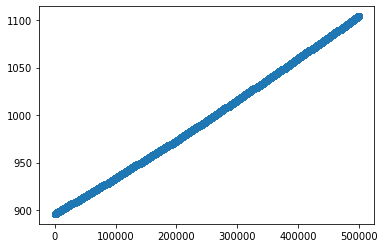

In [98]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(short_sums)), np.sort(short_sums))
plt.show()

In [97]:
np.sort(short_sums)[::-1][:2000]

array([1104, 1104, 1104, ..., 1103, 1103, 1103])

In [99]:
np.sum(short_sums < 1050)

378041

In [100]:
np.sum(short_sums > 1000)

234941

In [101]:
378041+234941-500000

112982

In [114]:
hl_sub = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000_subpops/european/",
                      train_inds,[6], "all")

In [115]:
len(hl_sub), hl_sub.pop_labels[2]

(237, 40)

In [6]:
loader22 = HyperLoader("/scratch/users/patelas/hyperLAI/snp_data/",
                      train_inds,[0,1,2,3,4,5,6], 22)

start reading ...
File read: 317408 SNPs for 3558 individuals
done loading vcf... Shape of vcf file is :  (317408, 3558, 2) Shape of vcf names file is (3558,)
TSV loaded Index(['Sample', 'Population code', 'Population', 'Superpopulation code',
       'Superpopulation', 'Source', 'Latitude', 'Longitude', 'Region',
       'Sample Alias', 'Country', 'Town', 'Single_Ancestry'],
      dtype='object') DF shape is  (3558, 13)
Super population code are ,  ['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS'] 7
Population code are ,  ['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL', 'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH', nan] 27
Population names are ,  ['British', 'Finnish', 'Southern Han Chinese', 'Puerto Rican', 'Dai Chinese', 'Colombian', 'Spanish', 'Peruvian', 'Punjabi', 'Kinh Vietnamese', 'African-Caribbean', 'Gambian Mandinka', 'Esan', 'Bengali', 'Mende', 'Sri Lankan', 'Indian Telugu', 'CEPH', 'Yorub

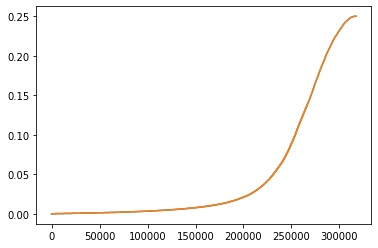

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.sort(np.var(loader22.snps, axis=0)))
plt.show()

In [1]:
import numpy as np
np.var([1] * 4743 + [0])

0.0002107481465893547